# 📊 Exploratory Data Analysis: Korean vs Western Skincare

We explore trends in price, product type, ratings, and ingredient count using cleaned skincare product data.

Focus: comparing **Korean (Olive Young)** and **Western (Sephora)** products to reveal cultural skincare preferences.

---

### Questions:
- What ingredients are most common in each region?
- Which products are more expensive or highly rated?
- Are there differences in product variety or formulation styles?

In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

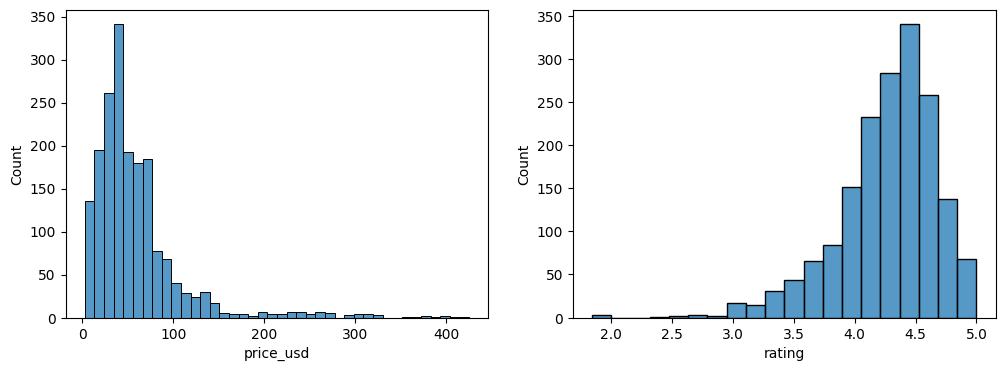

Average price per product type
type
Moisturizers               77.37
Face Serums                73.26
Eye Creams & Treatments    68.82
Mists & Essences           64.13
Face Oils                  62.25
Night Creams               61.76
Facial Peels               53.75
Exfoliators                48.96
Face Masks                 48.79
Face Sunscreen             44.91
Sheet Masks                39.17
Eye Masks                  38.39
Treatments                 37.54
Cleansers                  36.00
Sunscreen                  34.67
Face Wash & Cleansers      34.64
Toners                     34.46
Lip Balms & Treatments     24.81
Name: price_usd, dtype: float64


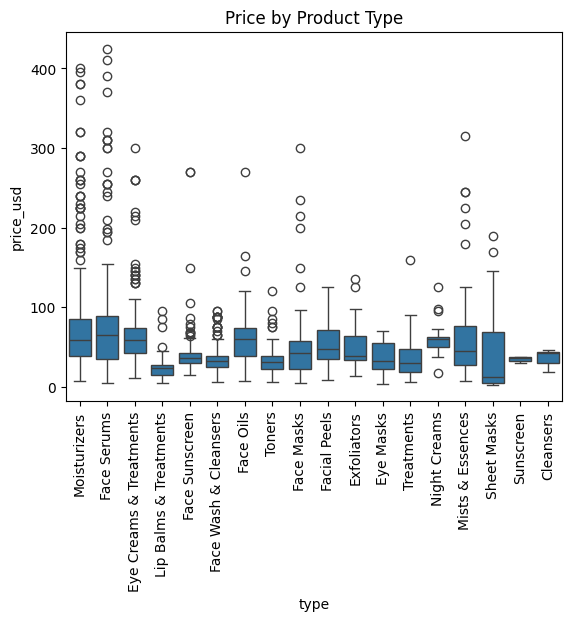

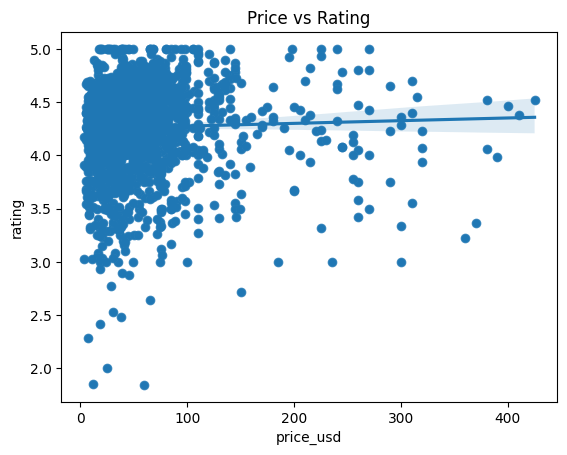

In [2]:
#SEPHORA INITIAL EDA 

products_sephora = pd.read_csv('/Users/sarahhyun/skincare/data/sephora/sephora_cleaned.csv')
fig, axes = plt.subplots(1,2, figsize = (12, 4))
sns.histplot(data=products_sephora, x = 'price_usd', bins=40, ax=axes[0])
sns.histplot(data=products_sephora.dropna(), x = 'rating', bins=20, ax=axes[1])
plt.show()

print("Average price per product type")
print(round(products_sephora.groupby('type')['price_usd'].mean().sort_values(ascending=False), 2))

#price by category
sns.boxplot(products_sephora, x='type', y = 'price_usd')
plt.title('Price by Product Type')
plt.xticks(rotation=90)
plt.show()


#price to rating scatterplot
q99 = products_sephora['price_usd'].quantile(0.99)
clip = products_sephora[products_sephora['price_usd'] <= q99]

# plt.figure(figsize=(6,4))
sns.scatterplot(data=products_sephora, x='price_usd', y='rating')
sns.regplot(data=products_sephora, x='price_usd', y='rating')
plt.title('Price vs Rating')
plt.show()



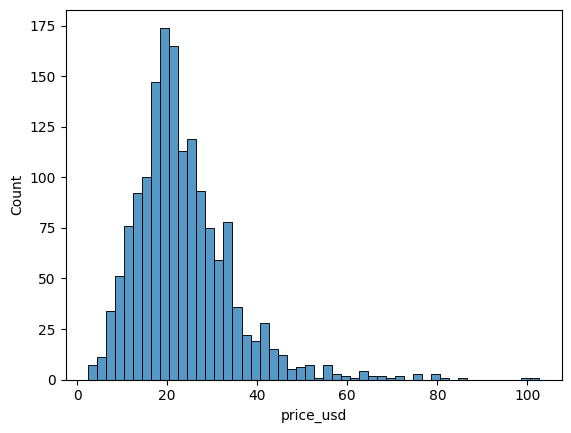

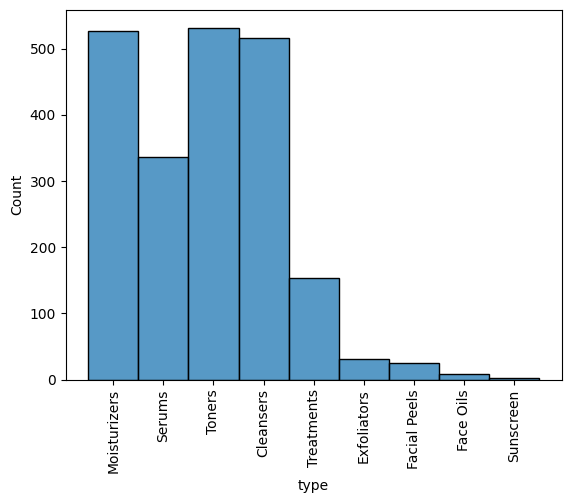

Average price per product type
type
Sunscreen       31.75
Moisturizers    27.48
Serums          27.20
Toners          25.56
Face Oils       24.64
Exfoliators     19.97
Cleansers       18.45
Treatments      14.99
Facial Peels    14.96
Name: price_usd, dtype: float64


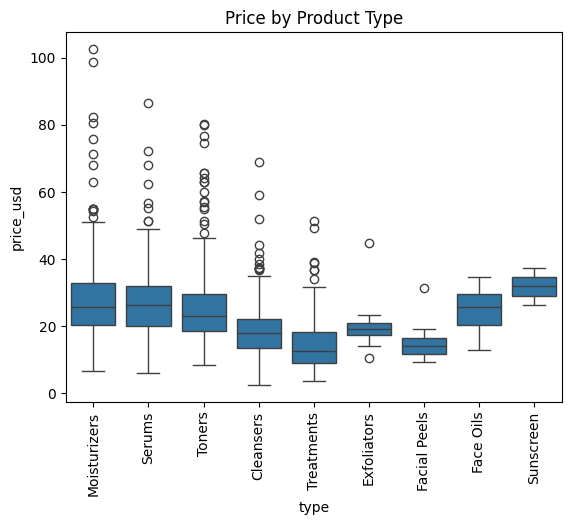

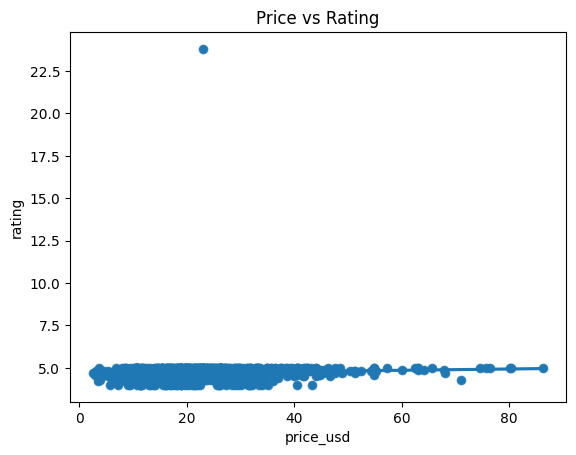

In [6]:
#OLIVE YOUNG INITIAL EDA
products_olive = pd.read_csv('/Users/sarahhyun/skincare/data/olive/olive_cleaned.csv')
sns.histplot(data=products_olive, x = 'price_usd')
plt.show()
sns.histplot(data=products_olive, x = 'type')
plt.xticks(rotation=90)
plt.show()

print("Average price per product type")
print(round(products_olive.groupby('type')['price_usd'].mean().sort_values(ascending=False), 2))

#price by category
sns.boxplot(products_olive, x='type', y = products_olive['price_usd'].dropna())
plt.title('Price by Product Type')
plt.xticks(rotation=90)
plt.show()


#price to rating scatterplot
q99 = products_olive['price_usd'].quantile(0.99)
clip = products_olive[products_olive['price_usd'] <= q99]

# plt.figure(figsize=(6,4))
sns.scatterplot(data=products_olive, x='price_usd', y='rating')
sns.regplot(data=products_olive, x='price_usd', y='rating')
plt.title('Price vs Rating')
plt.show()


# FULL SKINCARE DATASET ANALYSIS 
    01 - Summary: high level overview
    02 - Ingredient Analysis: heat map of top ingredients used per product  
    03 - Plots: western vs kbeauty analysis 
    04 - Value Score: what products are worth it based on reviews and price


In [8]:
# 01 SUMMARY 
skincare_full =pd.read_csv('/Users/sarahhyun/skincare/data/skincare_full.csv')
skincare_full = skincare_full[skincare_full['rating'] < 15] #there was a random product with rating of 23 that was removed 
skincare_full.groupby('source')[['price_usd', 'rating']].agg(['mean', 'median', 'count', 'max', 'min']), round(2)

(                 price_usd                               rating                \
                       mean  median count    max   min      mean  median count   
 source                                                                          
 kbeauty_olive    23.413076  21.805  1804   86.4  2.45  4.683496  4.7000  2254   
 western_sephora  58.704266  45.000  1819  425.0  3.00  4.264061  4.3333  1819   
 
                               
                  max     min  
 source                        
 kbeauty_olive    5.0  4.0000  
 western_sephora  5.0  1.8462  ,
 2)

source
kbeauty_olive      39.372671
western_sephora    34.344145
Name: ingredient_count, dtype: float64


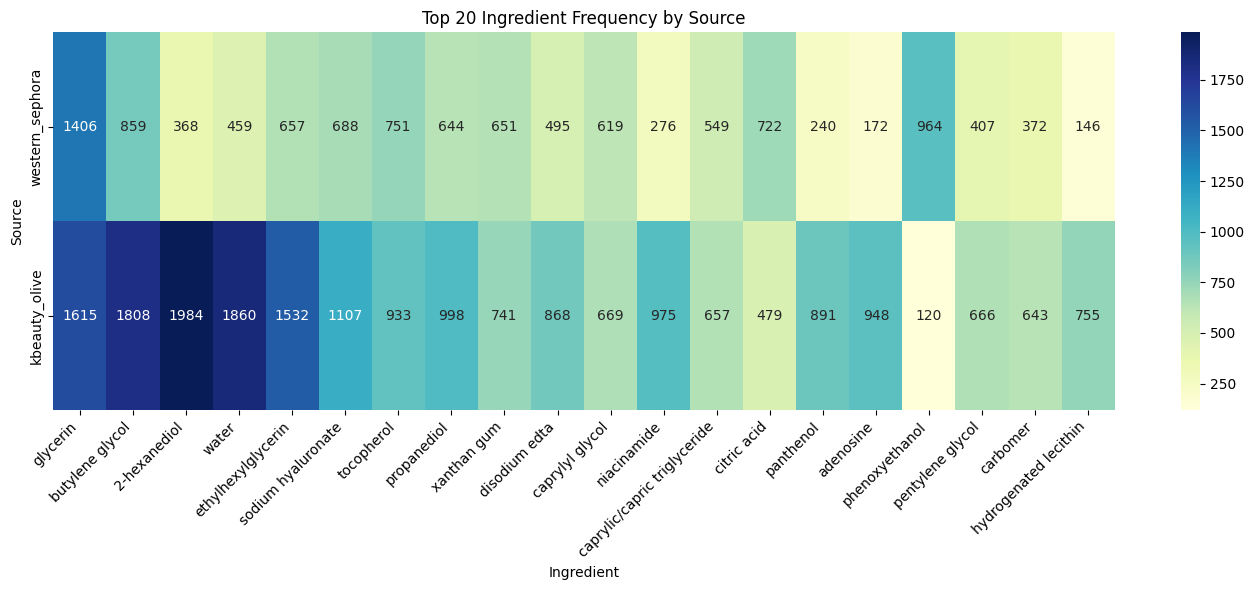

In [13]:
# 02 INGREDIENT ANALYSIS

from collections import Counter

# Average number of ingredients per product
skincare_full['ingredient_count'] = skincare_full['ingredients'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)
print(skincare_full.groupby('source')['ingredient_count'].mean())

#Tokenize ingredients per source (western_sephora vs korean_oliveyoung, etc.)
source_ingredient_counts = {}

for source in skincare_full['source'].unique():
    # Filter rows by source
    source_df = skincare_full[skincare_full['source'] == source]
    ingredient_lists = source_df['ingredients'].dropna().str.lower().str.split(',')

    # Flatten and clean
    flat_ingredients = [
        ingredient.strip()
        for sublist in ingredient_lists
        for ingredient in sublist
        if ingredient.strip() != '1'
    ]
    
    # Count
    source_ingredient_counts[source] = Counter(flat_ingredients)

# Combine counts into a DataFrame
all_ingredients = set().union(*[set(c) for c in source_ingredient_counts.values()])
ingredient_freq_df = pd.DataFrame(index=sorted(all_ingredients))

for source, counts in source_ingredient_counts.items():
    ingredient_freq_df[source] = ingredient_freq_df.index.map(lambda x: counts.get(x, 0))

#Focus on top 20 ingredients overall
top_ingredients = ingredient_freq_df.sum(axis=1).sort_values(ascending=False).head(20).index
heatmap_data = ingredient_freq_df.loc[top_ingredients]

#Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data.T, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Top 20 Ingredient Frequency by Source')
plt.ylabel('Source')
plt.xlabel('Ingredient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("ingredient_heat.png", dpi=300, bbox_inches='tight')
plt.show()


The heat map above show how k-Beauty products tend to use more hydrating and soothing ingredients such as glycerin, panthenol and niacinamide. Significant use of water in kbeauty products might suggest that k-beauty products are more water based, emulsion formulas. Also appears that kbeauty products have more ingredients per product than western beauty products. K-Beauty tends to include more botanical extracts and fermented ingredients, while Western products focus more on actives like retinol and peptides.

💡 Future Work:
- Add clustering based on ingredient similarity
- Analyze ingredient safety classifications
- Build a personalized skincare recommender (e.g., by skin concern and budget)


In [14]:
#missed some type value cleanup. Consolidating some values for simplicity  

type_mapping = {
    'Face Serums': 'Serums',
    'Face Wash & Cleansers': 'Cleansers',
    'Night Creams': 'Moisturizers',
    'Eye Creams & Treatments': 'Moisturizers',
    'Lip Balms & Treatments': 'Treatments',
    'Mists & Essences': 'Toners',
    'Face Sunscreen': 'Sunscreen',
    'Facial Peels': 'Treatments',
    'Face Wash & Cleansers': 'Cleansers',
    'Eye Masks': 'Treatments',
    'Face Masks': 'Treatments',
    'Eye Creams': 'Moisturizers',
    'Sheet Masks': 'Treatments'
}
skincare_full['type'] = skincare_full['type'].replace(type_mapping)
skincare_full.type.value_counts().sort_index()
skincare_full.to_csv('final_skincare_products.csv', index = False)

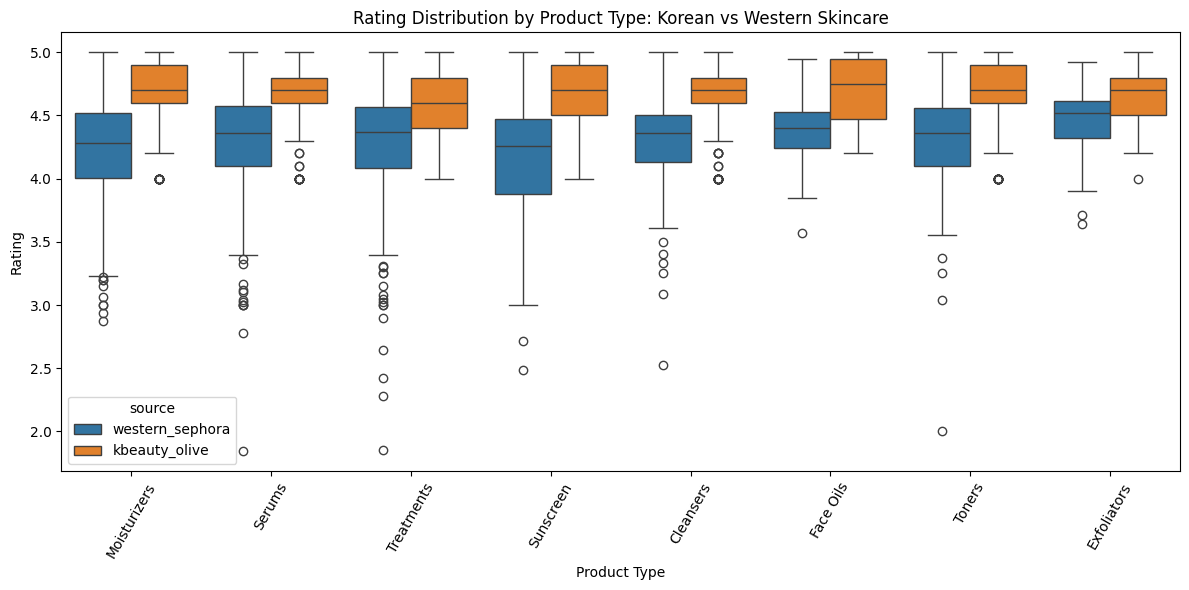

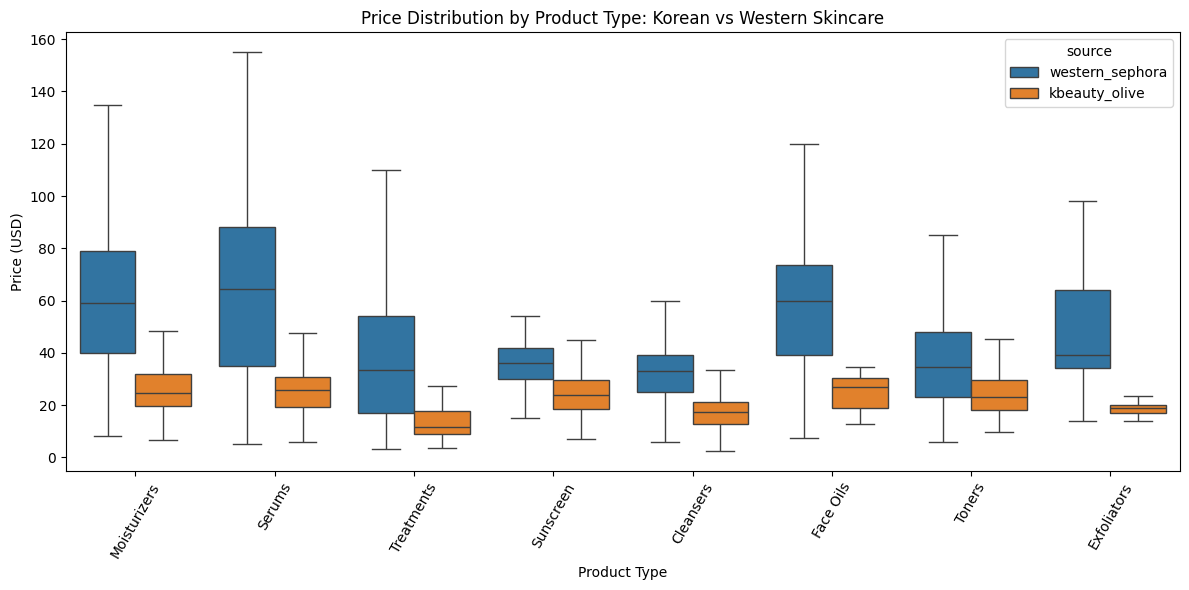

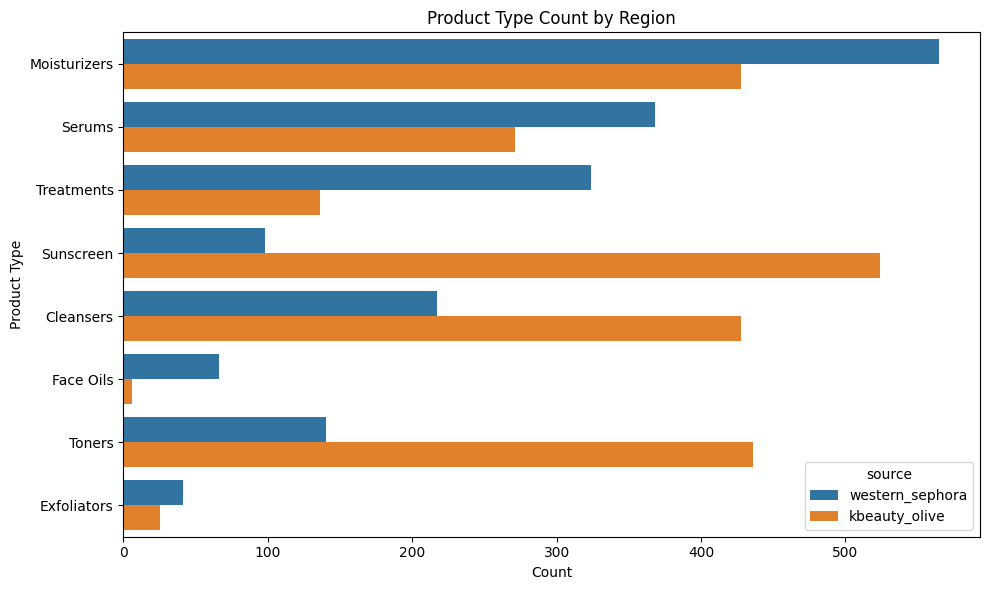

In [15]:
# 03 PLOTS

# Plot: Rating distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=skincare_full, x='type', y='rating', hue='source')
plt.title('Rating Distribution by Product Type: Korean vs Western Skincare')
plt.xlabel('Product Type')
plt.ylabel('Rating')
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig("Rating_Product_Type.png", dpi=300, bbox_inches='tight')
plt.show()


# Plot: Price distribution 
plt.figure(figsize=(12, 6))
sns.boxplot(data=skincare_full, x='type', y='price_usd', hue='source', showfliers = False)
plt.title('Price Distribution by Product Type: Korean vs Western Skincare')
plt.xlabel('Product Type')
plt.ylabel('Price (USD)')
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig("Price_Product_Type.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot: Top products
plt.figure(figsize=(10, 6))
sns.countplot(data=skincare_full, y='type', hue='source')
plt.title('Product Type Count by Region')
plt.xlabel('Count')
plt.ylabel('Product Type')
plt.tight_layout()
plt.savefig("Product_Type_Region.png", dpi=300, bbox_inches='tight')
plt.show()


# Ratings
Interestingly, both regions show high user satisfaction, with **Korean products having a slightly higher average rating**.

This may reflect:
- Strong user trust in Korean formulations
- The influence of community-driven product reviews on Olive Young and similar platforms

However, the rating systems between platforms may differ slightly, so interpret with caution.

# Price
Notable trends:
- Western products tend to have higher median prices across most product types
- **Serums and masks** are the most expensive categories on average
- **Toners and cleansers** are among the most affordable, especially in K-Beauty

Korean products appear more affordable overall, aligning with K-Beauty’s reputation for accessible, high-quality formulations.

As expected, Western products are generally more expensive than Korean ones.

This may be due to:
- Brand positioning (premium skincare in Western markets)
- Regional pricing strategies
- Supply chain costs and marketing budgets

Korean skincare appears to offer **more ingredients per product** and **lower price per ml**, making it attractive for budget-conscious consumers.


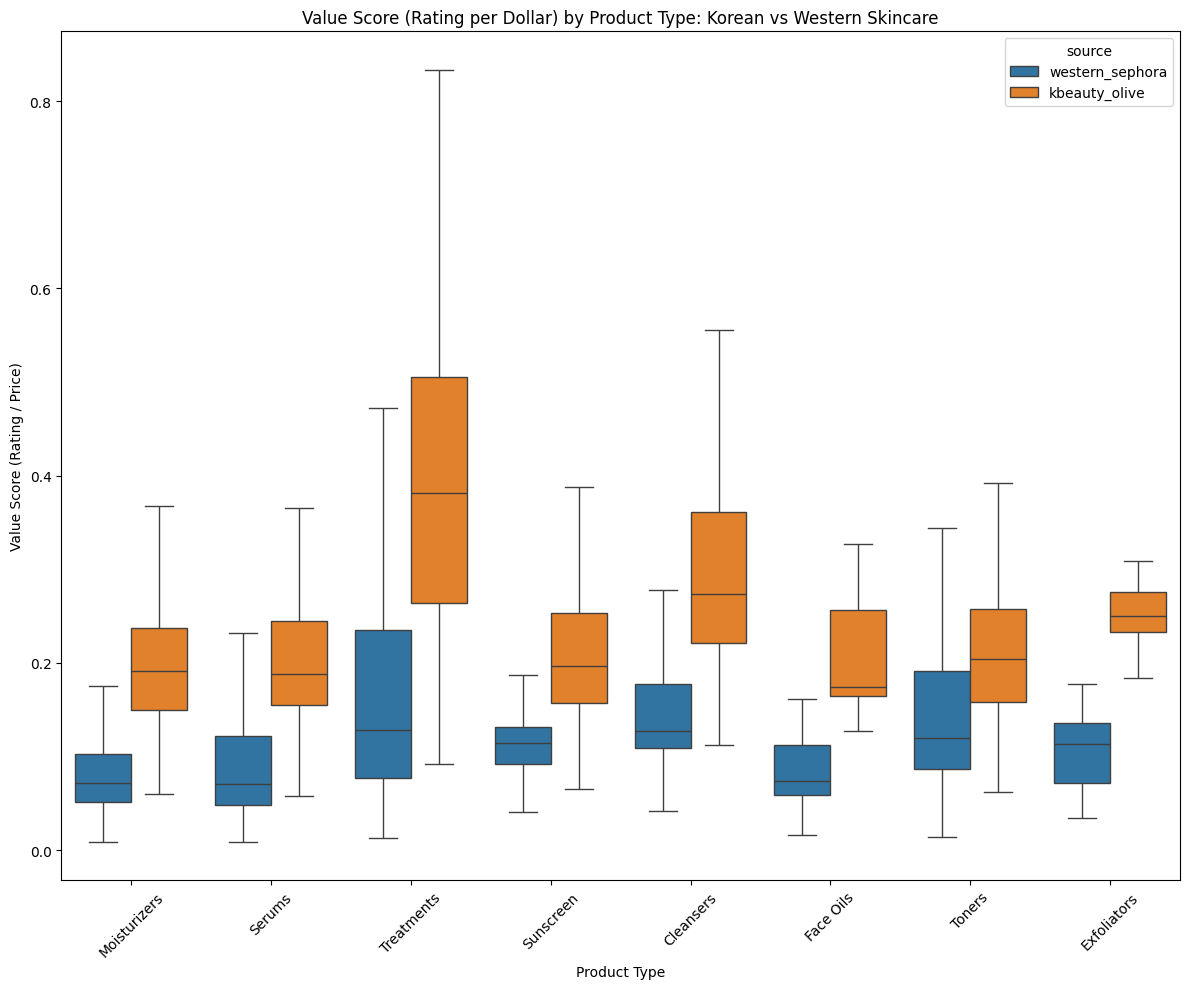

In [16]:
# 04 VALUE SCORE

#adding a value score to my dataset based on rating & price
skincare_full['value_score'] = skincare_full['rating']/skincare_full['price_usd']
skincare_full.describe()

plt.figure(figsize=(12, 10))
sns.boxplot(data=skincare_full, x='type', y='value_score', hue='source', showfliers = False)
plt.title('Value Score (Rating per Dollar) by Product Type: Korean vs Western Skincare')
plt.xlabel('Product Type')
plt.ylabel('Value Score (Rating / Price)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("value_score.png", dpi=300, bbox_inches='tight')
plt.show()